# Ridge Regression

In this tutorial section, we demonstrate a ridge regression example using SketchyOpts. We first introduce some useful notations. 
<!-- - $X \in \mathbb{R}^{n \times p}$: input features (or design matrix)
- $y \in \mathbb{R}^{n}$: target labels
- $(x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}$: $i$<sup>th</sup> training sample
- $\beta \in \mathbb{R}^{p}$: parameters of the model (or ridge estimator)
- $\lambda \geqslant 0$: regularization strength of the model
 -->
| Symbol | Description |
| --- | --- |
| $X \in \mathbb{R}^{n \times p}$ | input features (or design matrix) |
| $y \in \mathbb{R}^{n}$ | target labels |
| $(x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}$ | $i$<sup>th</sup> training sample |
| $\beta \in \mathbb{R}^{p}$ | parameters of the model (or ridge estimator) |
| $\lambda \geqslant 0$ | regularization strength of the model |

Ridge regression seek to solve the optimization problem of the following form
$$
    \underset{\beta}{\operatorname{minimize}} ~ \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} (x_i^{\mathsf{T}} \beta - y_i)^2 + \frac{\lambda}{2} \lVert \beta \rVert_2^2
$$

From the objective, we see the problem can be viewed as least-squares with an additional sum-of-squares penalty term of the model parameters $\beta$. In fact, ridge regression is an example of shrinkage method that aims to reduce the variance of the estimates by purposefully introducing bias. The value of $\lambda$ controls the level of shrinkage—the larger the value of $\lambda$, the more model parameters are shrunk toward zero as well as each other. In practice, $\lambda$ is chosen so that the resulting model achieves better generalizability (_e.g._ reduced test error). 

## Dataset

In the following example, we use the `yolanda` dataset from the [AutoML Challenge](https://automl.chalearn.org/data) {cite}`rr-guyon2019analysis`. The original dataset consists of 400,000 training samples and 30,000 test samples where each sample has 100 numerical features. Since the labels on the test data were never published, we instead randomly split the training data into training and test subsets with a 80/20 ratio. We opt to obtain the dataset from [OpenML](https://www.openml.org/d/42705) over the [original source](https://competitions.codalab.org/my/datasets/download/41847153-1338-4514-a693-547f1288e8c4) as the former is readily supported by the [scikit-learn API](https://scikit-learn.org/stable/datasets/loading_other_datasets.html#downloading-datasets-from-the-openml-org-repository). 

As a pre-processing step, we first standardize input features as well as target labels, and then apply random Fourier features transformation {cite}`rr-rahimi2007random`. Standardization of the input is often necesary as the solution to the ridge objective is not equivariant under scaling of the inputs, whereas standardization of the label is for convenience as the intercept in this case becomes trivial and thus can be safely ignored. To see this, note that since the inputs are standardized (hence centered), the intercept can be estimated by $(1/n) \sum_{i=1}^{n} y_i$ which evaluates to zero if the label is also standardized (or simply centered). Lastly, the random features transformation efficiently approximates a kernel function and leads to small effective dimension of the Hessian that preconditioned methods like PROMISE {cite}`rr-frangella2024promise` are able to effectively leverage. 


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# set seed for reproducibility
seed = 0
rng = np.random.default_rng(seed)

# download dataset
X, y = fetch_openml(data_id=42705, return_X_y=True)
X, y = X.to_numpy(), y.to_numpy()

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# standardize both sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1,1)).reshape(-1)
y_test = scaler.transform(y_test.reshape(-1,1)).reshape(-1)

# apply random features (Gaussian kernel)
p = 1000 # number of random features
         # please note that this is much smaller than 
         # what would have been (i.e. n_train) 
         # if we were to use kernel method directly
num_raw_features = X_train.shape[1]
W = rng.standard_normal((p, num_raw_features))
b = rng.uniform(0, 2*np.pi, p)
X_train = np.sqrt(2/p) * np.cos(X_train @ W.T + b)
X_test = np.sqrt(2/p) * np.cos(X_test @ W.T + b)

## Fitting the model

We first define the ridge objective function $f$. The function needs to be scalar-valued and have parameters, training data, and regularization constant as its arguments. Mathematically, the function can be expressed as the following

$$
    f(\beta, X, y, \lambda) := \frac{1}{2n} \big\lVert X\beta - y \big\rVert_2^2 + \frac{\lambda}{2} \lVert \beta \rVert_2^2
$$

We implement the objective with necessary changes to make it compatible with PROMISE solvers (SketchySAGA in particular). 

In [2]:
import jax.numpy as jnp

def compute_objective(params, X, y, reg): 
    return (1 /2) * jnp.mean(jnp.square(X @ params - y)) + (reg / 2) * jnp.dot(params, params)

def fun(params, data, reg): 
    # make data 2-dimensional if needed
    if jnp.ndim(data) == 1:
        data = jnp.expand_dims(data, axis=0)

    # slice data array to get features and labels
    X = data[:, :-1]
    y = data[:, -1]
    
    # compute objective
    obj = compute_objective(params, X, y, reg)

    return obj

The arguments `params`, `data`, and `reg` respectively correspond to $\beta$, $(X, y)$, and $\lambda$ described above. We would like to highlight a few points here. 

- `params` can be named differently but it has to be in the first position; `data` and `reg`, on the other hand, can be placed in any position but must have the exact argument names.
- Input features $X$ and target labels $y$ are fused into a single 2-dimensional array `data`; this requirement helps facilitate random sampling inside of the solver. 
- For all PROMISE solvers, `fun` needs to be compatible with 2-dimensional `data` input. However, for SketchySAGA, `fun` is also expected to accept 1-dimensional data input because the method utilizes gradient of each individual component of the objective function. 
- It is not neccesary to JIT-compile `fun` (or `grad_fun`, `hvp_fun`, `sqrt_hess_fun`) beforehand as the solver will transform the function internally if ``jit = True``{l=python}.

Next we define a custom callback function that evaluates the fitted model and keeps track of training loss at every 100 update steps. Here we adopt the mean square error (MSE) as our evaluation metric. 

In [3]:
import jax

# jit functions get called inside of the callback
def compute_error(params, X, y): 
    return jnp.mean(jnp.square(X @ params - y))

get_train_loss = jax.jit(lambda p, r: compute_objective(p, X_train, y_train, r))
get_train_error = jax.jit(lambda p: compute_error(p, X_train, y_train))
get_test_error = jax.jit(lambda p: compute_error(p, X_test, y_test))

# initialize empty containers
train_loss = []
train_error = []
test_error = []

# define the callback function
eval_freq = 100
def callback(params, state, data, reg): 
    # perform computations every 100 iterations
    if state.iter_num % eval_freq == 0: 
        # record training loss
        train_loss.append(get_train_loss(params, reg))

        # evaluate both training and test errors
        train_error.append(get_train_error(params))
        test_error.append(get_test_error(params))
    
    return params, state

```{note}
You may have noticed that components of callback function are JIT-compiled because unlike `fun` (or `grad_fun`, `hvp_fun`, `sqrt_hess_fun`), the `jit` argument does not apply to the custom pre-update function. Since we expect the function to be executed multiple times during the run, JIT-compiling it could bring performance improvement. 

Please also note that the callback used in this example is inherently not functionally pure as it writes to external lists outside of the function. This means we cannot simply JIT-compile the entire function; instead, we JIT-compile individual components inside of the function. 
```

```{seealso}
For more details on pure function, please see [JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions). 
```

We now specify hyperparameters and fit the model using SketchySAGA (with the Nyström subsampled Newton preconditioner). Rank and regularization for the preconditioner are set to their default values ($10$ and $10^{-3}$ respectively). Since the ridge objective has a constant Hessian, we set the preconditioner update frequency to $0$ so that it is only computed once and held constant throughout the run. The rest follows the recommended values discussed in the PROMISE paper {cite}`rr-frangella2024promise`. In this example, we arbitrarily set the regularization strength $\lambda = 0.01/n$ to demonstrate the performance of SketchySAGA as this small value is not likely to meaningfully improve the conditioning of the problem. As explained in the introduction, this value in practice is typically chosen via a more principled approach like cross-validation. 

In [4]:
from sketchyopts.solver import SketchySAGA

# specify hyperparameters
grad_batch_size = 256
hess_batch_size = int(np.floor(np.sqrt(n_train)))
update_freq = 0
maxiter = 20000
tol = 1e-6

init_params = jnp.zeros(p)
data = jnp.hstack([X_train, y_train.reshape(-1,1)])
reg = 0.01 / n_train

# initialize the solver and start the optimization
opt = SketchySAGA(fun=fun, 
                  pre_update=callback, 
                  grad_batch_size=grad_batch_size, 
                  hess_batch_size=hess_batch_size, 
                  update_freq=update_freq, 
                  seed=seed, 
                  maxiter=maxiter, 
                  tol=tol)
params, state = opt.run(init_params, data, reg)

We visualize how suboptimality gap and errors evolve throughout the run. The optimal solution is obtained by running LSQR {cite}`rr-paige1982lsqr` with [scikit-learn API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). 

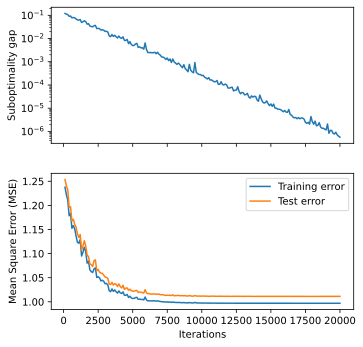

In [5]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# obtain the optimal solution
clf = Ridge(alpha=reg * n_train, fit_intercept=False, tol=tol, solver='lsqr')
clf.fit(X_train, y_train)
opt_val = get_train_loss(clf.coef_, reg)

# update plot settings
%config InlineBackend.figure_formats = ['svg']
plt.rcParams.update({'font.size': 10})

# manually evaluate the resulting parameters
# as the callback only gets called before each update
train_loss.append(get_train_loss(params, reg))
train_error.append(get_train_error(params))
test_error.append(get_test_error(params))

# compute suboptimality gap
subopt_gap = np.array(train_loss) - opt_val

# make subplots
fig, axes = plt.subplots(2, sharex=True, subplot_kw=dict(box_aspect=0.45))
plt.tight_layout(h_pad=2)

# plot suboptimality gap]
iter_nums = np.arange(eval_freq, maxiter+1, eval_freq)
axes[0].semilogy(iter_nums, subopt_gap[1:])
axes[0].set_ylabel('Suboptimality gap')

# plot training and test errors
axes[1].plot(iter_nums, train_error[1:], label='Training error')
axes[1].plot(iter_nums, test_error[1:], label='Test error')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Mean Square Error (MSE)')
axes[1].legend()

plt.show()

We observe SketchySAGA continuously makes progress toward the minimum. If we run the solver long enough (currently capped at 20000 iterations), the suboptimality gap will eventually reach machine precision of a single floating-point representation. 

```{note}
Please note that JAX by default enforces single-precision values. As a result, without explicitly configuring JAX to double-precision, SketchyOpts also operates in single-precision. For more details, please see [JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision).
```

## Remarks

In this example, hyperparameters of the preconditioner were set to their default values. We might get a faster convergence from a larger rank value, though the effect depends on the spetrum of the dataset. If you expect the dataset to exhibit spectral decay, then tuning rank value could lead to improvement in convergence. 

Another pratical suggestion we would like to make is enbaling JIT-compilation could make a difference. Although the compilation process takes additional time before the actual code execution, the time saved up from each subsequent calls to the JIT-compiled functions can make this trade-off worthwhile, especially if the solver is expected to run an extended number of iterations. For a problem that requires frequent update to the preconditioner, the performance parity is going to be even more pronounced. 

## References

```{bibliography}
:labelprefix: RR
:keyprefix: rr-
```